# Docker Container

In [1]:
# docker run -it --name sparkr-jupy --mount type=bind,source=C:/Users/soumy/OneDrive/Coding,target=/app/data --rm -p 8888:8888 quay.io/jupyter/all-spark-notebook

# Library

In [2]:
library(SparkR)
library(dplyr)
library(ggplot2)


Attaching package: ‘SparkR’


The following objects are masked from ‘package:stats’:

    cov, filter, lag, na.omit, predict, sd, var, window


The following objects are masked from ‘package:base’:

    as.data.frame, colnames, colnames<-, drop, endsWith, intersect,
    rank, rbind, sample, startsWith, subset, summary, transform, union



Attaching package: ‘dplyr’


The following objects are masked from ‘package:SparkR’:

    arrange, between, coalesce, collect, contains, count, cume_dist,
    dense_rank, desc, distinct, explain, expr, filter, first, group_by,
    intersect, lag, last, lead, mutate, n, n_distinct, ntile,
    percent_rank, rename, row_number, sample_frac, select, slice, sql,
    summarize, union, where


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘ggplot2’


The following object is masked from ‘package:SparkR’:

    expr



# Creating spark session

In [3]:
sparkR.session()
if (nchar(Sys.getenv("SPARK_HOME")) < 1) {
  Sys.setenv(SPARK_HOME = "/home/spark")
}
library(SparkR, lib.loc = c(file.path(Sys.getenv("SPARK_HOME"), "R", "lib")))
sparkR.session(master = "local[*]",
               sparkConfig = list(spark.driver.memory = "2g"))

Warning message in sparkR.session():
“SparkR is deprecated from Apache Spark 4.0.0 and will be removed in a future version.”
Spark package found in SPARK_HOME: /usr/local/spark



Launching java with spark-submit command /usr/local/spark/bin/spark-submit   sparkr-shell /tmp/Rtmp6sjG3e/backend_port49046843463f 


Java ref type org.apache.spark.sql.SparkSession id 1 

Warning message in sparkR.session(master = "local[*]", sparkConfig = list(spark.driver.memory = "2g")):
“SparkR is deprecated from Apache Spark 4.0.0 and will be removed in a future version.”


Java ref type org.apache.spark.sql.SparkSession id 1 

# Read Data

In [4]:
df_raw <- loadDF(
  path = "/app/data/R/SparkR_test/SparkR_test/all_stocks_5yr.csv", # File path
  source = "csv", # file type
  header = "true", # data have header or not
  inferSchema = "true" # auto column type prediction
)
df <- repartition(df_raw, 5) # partition the data

showDF(df, 5)

+----------+------+-------+-------+------+-------+----+
|      date|  open|   high|    low| close| volume|Name|
+----------+------+-------+-------+------+-------+----+
|2014-05-05|  74.5|  74.66|  73.76| 74.51|4348608| BAX|
|2014-01-14| 47.16| 47.894|  46.91|  47.8|2338221|ALLE|
|2016-05-26|212.66|214.115| 210.23|212.05| 422492| ADS|
|2016-05-18|210.84|  214.7|208.647|212.63| 893043| ADS|
|2015-06-17|139.75|140.148| 139.08|139.76| 650779| BDX|
+----------+------+-------+-------+------+-------+----+
only showing top 5 rows


# Select columns

In [5]:
temp <- SparkR::select(df, # Dataframe
  c("date", "open") # Column names to select
)

showDF(temp, 5)

+----------+------+
|      date|  open|
+----------+------+
|2016-12-22|123.72|
|2015-03-09|31.495|
|2013-12-02| 23.55|
|2014-01-22| 86.91|
|2014-08-06|149.21|
+----------+------+
only showing top 5 rows


# Select rows

In [6]:
# Select first 3 rows
temp <- limit(df, 3)

showDF(temp)

+----------+------+-------+------+------+-------+----+
|      date|  open|   high|   low| close| volume|Name|
+----------+------+-------+------+------+-------+----+
|2014-05-05|  74.5|  74.66| 73.76| 74.51|4348608| BAX|
|2014-01-14| 47.16| 47.894| 46.91|  47.8|2338221|ALLE|
|2016-05-26|212.66|214.115|210.23|212.05| 422492| ADS|
+----------+------+-------+------+------+-------+----+


# Filter Data

In [7]:
temp <- SparkR::filter(df, 
    df$open > 100 & df$low < 100 # filter condition
)

showDF(temp, 5)

+----------+------+------+-------+------+-------+----+
|      date|  open|  high|    low| close| volume|Name|
+----------+------+------+-------+------+-------+----+
|2016-03-22|100.08|100.37| 99.455| 99.93|1435782| AMT|
|2017-12-27|101.72|101.72|   99.4| 99.77| 988503| AAP|
|2014-12-10|100.22| 101.1|  99.97|100.17|1826854| AMT|
|2015-08-20|102.18|103.66|  99.87| 99.97|3459881| ACN|
|2014-12-08| 104.0|104.17|99.6556|100.71|3484193|AVGO|
+----------+------+------+-------+------+-------+----+
only showing top 5 rows


# Schema

In [8]:
schema(df)

StructType
|-name = "date", type = "DateType", nullable = TRUE
|-name = "open", type = "DoubleType", nullable = TRUE
|-name = "high", type = "DoubleType", nullable = TRUE
|-name = "low", type = "DoubleType", nullable = TRUE
|-name = "close", type = "DoubleType", nullable = TRUE
|-name = "volume", type = "IntegerType", nullable = TRUE
|-name = "Name", type = "StringType", nullable = TRUE

# Pivot Longer

In [9]:
# Pivot Longer function
pivot_longer_sparkr <- function(df, id_cols, name_col, value_col) {
  library(SparkR)
  # Get all column names from the DataFrame
  all_cols <- colnames(df)
  # Identify the columns to pivot by excluding the specified columns
  cols_to_longer <- setdiff(all_cols, id_cols)
  # Use stack to pivot the columns
  long_df <- unpivot(df, id_cols, cols_to_longer, name_col, value_col)
  return(long_df)
}

# Applying the function
temp <- pivot_longer_sparkr(df, id_cols = c("date", "Name"),
                            name_col = "Metric", value_col = "Values")

showDF(temp, 5)

+----------+----+------+---------+
|      date|Name|Metric|   Values|
+----------+----+------+---------+
|2014-05-05| BAX|  open|     74.5|
|2014-05-05| BAX|  high|    74.66|
|2014-05-05| BAX|   low|    73.76|
|2014-05-05| BAX| close|    74.51|
|2014-05-05| BAX|volume|4348608.0|
+----------+----+------+---------+
only showing top 5 rows


# Pivot wider

In [10]:
temp_new <- sum(
    pivot(
        groupBy(
            temp, # dataframe
            "date", "Name" # id columns
            ), 
        "Metric" # column contains names
        ), 
    "Values" # value column
)
showDF(temp_new, 5)

+----------+----+------+------+-------+------+---------+
|      date|Name| close|  high|    low|  open|   volume|
+----------+----+------+------+-------+------+---------+
|2013-08-09| BXP|105.09| 105.3|102.605|103.07| 926912.0|
|2013-08-26|  PX|117.94|119.68| 117.85| 119.0| 768957.0|
|2014-03-06|  CB| 98.15| 98.57|  97.48| 97.78|1331091.0|
|2014-10-01| OMC| 67.44| 68.89|  67.22| 68.69|1625181.0|
|2014-11-13| WAT|113.72|114.32| 113.26| 113.5| 324729.0|
+----------+----+------+------+-------+------+---------+
only showing top 5 rows


# Column operation

In [11]:
temp <- withColumn(
    temp, # Dataframe
    "values_100", # column name
    temp$Values/100 # operation need to perform
)
showDF(temp, 5)

+----------+----+------+---------+------------------+
|      date|Name|Metric|   Values|        values_100|
+----------+----+------+---------+------------------+
|2014-05-05| BAX|  open|     74.5|             0.745|
|2014-05-05| BAX|  high|    74.66|0.7465999999999999|
|2014-05-05| BAX|   low|    73.76|            0.7376|
|2014-05-05| BAX| close|    74.51|0.7451000000000001|
|2014-05-05| BAX|volume|4348608.0|          43486.08|
+----------+----+------+---------+------------------+
only showing top 5 rows


# Replace a pattern

In [12]:
temp_new <- withColumn(temp, 
    "Metric_new", 
    regexp_replace(
        temp$Metric, # the column need to replace 
        "o", # the pattern need to replace
        "__" # by which to replace
    )
)
showDF(temp_new, 5)

+----------+----+------+---------+------------------+----------+
|      date|Name|Metric|   Values|        values_100|Metric_new|
+----------+----+------+---------+------------------+----------+
|2014-05-05| BAX|  open|     74.5|             0.745|     __pen|
|2014-05-05| BAX|  high|    74.66|0.7465999999999999|      high|
|2014-05-05| BAX|   low|    73.76|            0.7376|      l__w|
|2014-05-05| BAX| close|    74.51|0.7451000000000001|    cl__se|
|2014-05-05| BAX|volume|4348608.0|          43486.08|   v__lume|
+----------+----+------+---------+------------------+----------+
only showing top 5 rows


# Rename Columns

In [13]:
temp_new <- SparkR::withColumnRenamed(
    temp, # Dataframe
    "Name", # old name
    "name_test" # new name
)
showDF(temp_new, 5)

+----------+---------+------+---------+------------------+
|      date|name_test|Metric|   Values|        values_100|
+----------+---------+------+---------+------------------+
|2014-05-05|      BAX|  open|     74.5|             0.745|
|2014-05-05|      BAX|  high|    74.66|0.7465999999999999|
|2014-05-05|      BAX|   low|    73.76|            0.7376|
|2014-05-05|      BAX| close|    74.51|0.7451000000000001|
|2014-05-05|      BAX|volume|4348608.0|          43486.08|
+----------+---------+------+---------+------------------+
only showing top 5 rows


In [14]:
temp_new <- SparkR::rename(
    temp, # Dataframe
    name_test = temp$Name, # new_name = dataframe$old_name
    values_test = temp$Values # new_name = dataframe$old_name
)
showDF(temp_new, 5)

+----------+---------+------+-----------+------------------+
|      date|name_test|Metric|values_test|        values_100|
+----------+---------+------+-----------+------------------+
|2014-05-05|      BAX|  open|       74.5|             0.745|
|2014-05-05|      BAX|  high|      74.66|0.7465999999999999|
|2014-05-05|      BAX|   low|      73.76|            0.7376|
|2014-05-05|      BAX| close|      74.51|0.7451000000000001|
|2014-05-05|      BAX|volume|  4348608.0|          43486.08|
+----------+---------+------+-----------+------------------+
only showing top 5 rows


# Dimension of dataframe

In [15]:
dim(temp)

[1] 3095200       5

# Pipeline operation

## Example 1

In [16]:
temp_new <- temp %>% 
  withColumn("Metric", upper(temp$Metric)) %>% 
  SparkR::filter(rlike(temp$Metric, "o") & year(temp$date) != 2016) %>% 
  SparkR::mutate(
    name = lower(temp$Name),
    value = temp$Values * 100
  )

showDF(temp_new, 5)

+----------+----+------+---------+------------------+----+------------------+
|      date|Name|Metric|   Values|        values_100|name|             value|
+----------+----+------+---------+------------------+----+------------------+
|2014-05-05| BAX|  OPEN|     74.5|             0.745| bax|            7450.0|
|2014-05-05| BAX|   LOW|    73.76|            0.7376| bax| 7376.000000000001|
|2014-05-05| BAX| CLOSE|    74.51|0.7451000000000001| bax| 7451.000000000001|
|2014-05-05| BAX|VOLUME|4348608.0|          43486.08| bax|        4.348608E8|
|2014-01-09| AEE|  OPEN|    36.02|            0.3602| aee|3602.0000000000005|
+----------+----+------+---------+------------------+----+------------------+
only showing top 5 rows


## Example 2

In [17]:
temp_new <- temp %>% 
  SparkR::filter(temp$Metric %in% c("open", "close")) 

showDF(temp_new, 5)

+----------+----+------+------+-------------------+
|      date|Name|Metric|Values|         values_100|
+----------+----+------+------+-------------------+
|2014-05-05| BAX|  open|  74.5|              0.745|
|2014-05-05| BAX| close| 74.51| 0.7451000000000001|
|2014-01-14|ALLE|  open| 47.16|0.47159999999999996|
|2014-01-14|ALLE| close|  47.8|              0.478|
|2016-05-26| ADS|  open|212.66|             2.1266|
+----------+----+------+------+-------------------+
only showing top 5 rows


## Example 3

In [18]:
temp_new <- df %>% 
    SparkR::mutate(
        var = df$high - df$low
    ) 
temp_new <- temp_new %>% 
    SparkR::mutate(
        var_level = SparkR::ifelse(temp_new$var < 0, "Low", "High")
    )
showDF(temp_new, 5)

+----------+------+-------+-------+------+-------+----+------------------+---------+
|      date|  open|   high|    low| close| volume|Name|               var|var_level|
+----------+------+-------+-------+------+-------+----+------------------+---------+
|2014-05-05|  74.5|  74.66|  73.76| 74.51|4348608| BAX|0.8999999999999915|     High|
|2014-01-14| 47.16| 47.894|  46.91|  47.8|2338221|ALLE|0.9840000000000018|     High|
|2016-05-26|212.66|214.115| 210.23|212.05| 422492| ADS|3.8850000000000193|     High|
|2016-05-18|210.84|  214.7|208.647|212.63| 893043| ADS| 6.052999999999997|     High|
|2015-06-17|139.75|140.148| 139.08|139.76| 650779| BDX|1.0679999999999836|     High|
+----------+------+-------+-------+------+-------+----+------------------+---------+
only showing top 5 rows


# Exploratory Data Analysis

In [19]:
showDF(summary(df), 20)

+-------+-----------------+-----------------+-----------------+-----------------+-----------------+------+
|summary|             open|             high|              low|            close|           volume|  Name|
+-------+-----------------+-----------------+-----------------+-----------------+-----------------+------+
|  count|           619029|           619032|           619032|           619040|           619040|619040|
|   mean|83.02333431454844|83.77831069347327|82.25609641375269|  83.043762764765|4321823.395568945|  NULL|
| stddev|97.37876904332376| 98.2075189044637|96.50742105809051|97.38974800165839|8693609.511967573|  NULL|
|    min|             1.62|             1.69|              1.5|             1.59|                0|     A|
|    25%|            40.22|            40.62|            39.83|            40.25|          1070288|  NULL|
|    50%|            62.59|            63.15|            62.02|            62.62|          2081972|  NULL|
|    75%|            94.36|          

# Summarize

In [20]:
temp_new <- temp %>% 
    SparkR::group_by("date", "Metric") %>% # group by
    SparkR::summarize(                     # Summarization
        Sum = sum(temp$Values),
        min = min(temp$Values)
    )

showDF(temp_new, 5)

+----------+------+------------------+--------+
|      date|Metric|               Sum|     min|
+----------+------+------------------+--------+
|2015-02-23|volume|     1.761194847E9| 80474.0|
|2014-07-28|  high| 38600.35239999999|    3.78|
|2015-04-28| close|41963.850999999995|    2.31|
|2016-02-10|  open|        36948.0323|    1.92|
|2017-11-09|volume|     2.236264117E9|158938.0|
+----------+------+------------------+--------+
only showing top 5 rows


# Generalized Linear Regression

## Split into training & test

In [21]:
df_temp <- df %>% dropna() %>%  # removing NA
    SparkR::group_by("date") %>% 
    SparkR::summarize(
        open = sum(df$open, na.rm = TRUE), 
        close = sum(df$close, na.rm = TRUE),
        high = sum(df$high, na.rm = TRUE),
        low = sum(df$low, na.rm = TRUE),
        volume = sum(df$volume, na.rm = TRUE)
    )
df_list <- randomSplit(df_temp, c(9,1), 2) # 70% 30% split

train_df <- df_list[[1]]
test_df <- df_list[[2]]

## Model fitting

In [22]:
model_glm <- SparkR::spark.glm(train_df, volume ~ open + close + high + low, family = "gaussian")

# Check model summary
summary(model_glm)


Deviance Residuals: 
(Note: These are approximate quantiles with relative error <= 0.01)
        Min           1Q       Median           3Q          Max  
-1564225208   -164949526    -21048411    130514808   1777797016  

Coefficients:
               Estimate  Std. Error    t value  Pr(>|t|)
(Intercept)  2246807397    58134133   38.64868   0.00000
open              87254      116832    0.74684   0.45532
close             29382       86472    0.33978   0.73408
high            1453743      107752   13.49160   0.00000
low            -1601420       99662  -16.06847   0.00000

(Dispersion parameter for gaussian family taken to be 9.635051e+16)

    Null deviance: 2.3994e+20  on 1137  degrees of freedom
Residual deviance: 1.0917e+20  on 1133  degrees of freedom
AIC: 47740

Number of Fisher Scoring iterations: 1


## Prediction

In [23]:
# Check model prediction
df_predict <- predict(model_glm, test_df)
showDF(df_predict, 5)

+----------+------------------+------------------+------------------+------------------+----------+-------------+--------------------+
|      date|              open|             close|              high|               low|    volume|        label|          prediction|
+----------+------------------+------------------+------------------+------------------+----------+-------------+--------------------+
|2013-03-19|28388.366800000003|28238.302899999995|28550.466200000003|        27997.1566|2536821186|2.536821186E9|2.2233139269439154E9|
|2013-03-22|28296.471799999996|28368.529499999997|28513.505900000007|28130.500600000003|2114561134|2.114561134E9|1.9518513828534842E9|
|2013-04-09|28602.088300000003|28603.935400000002|        28812.0213|28350.624299999996|2065979480| 2.06597948E9| 2.066888332638114E9|
|2013-04-16|28516.514799999997|         28732.831| 28854.21699999999|28276.612500000003|2324197183|2.324197183E9|2.2430745559758368E9|
|2013-04-25| 29002.04899999999|        29088.2944|29391

## Plot

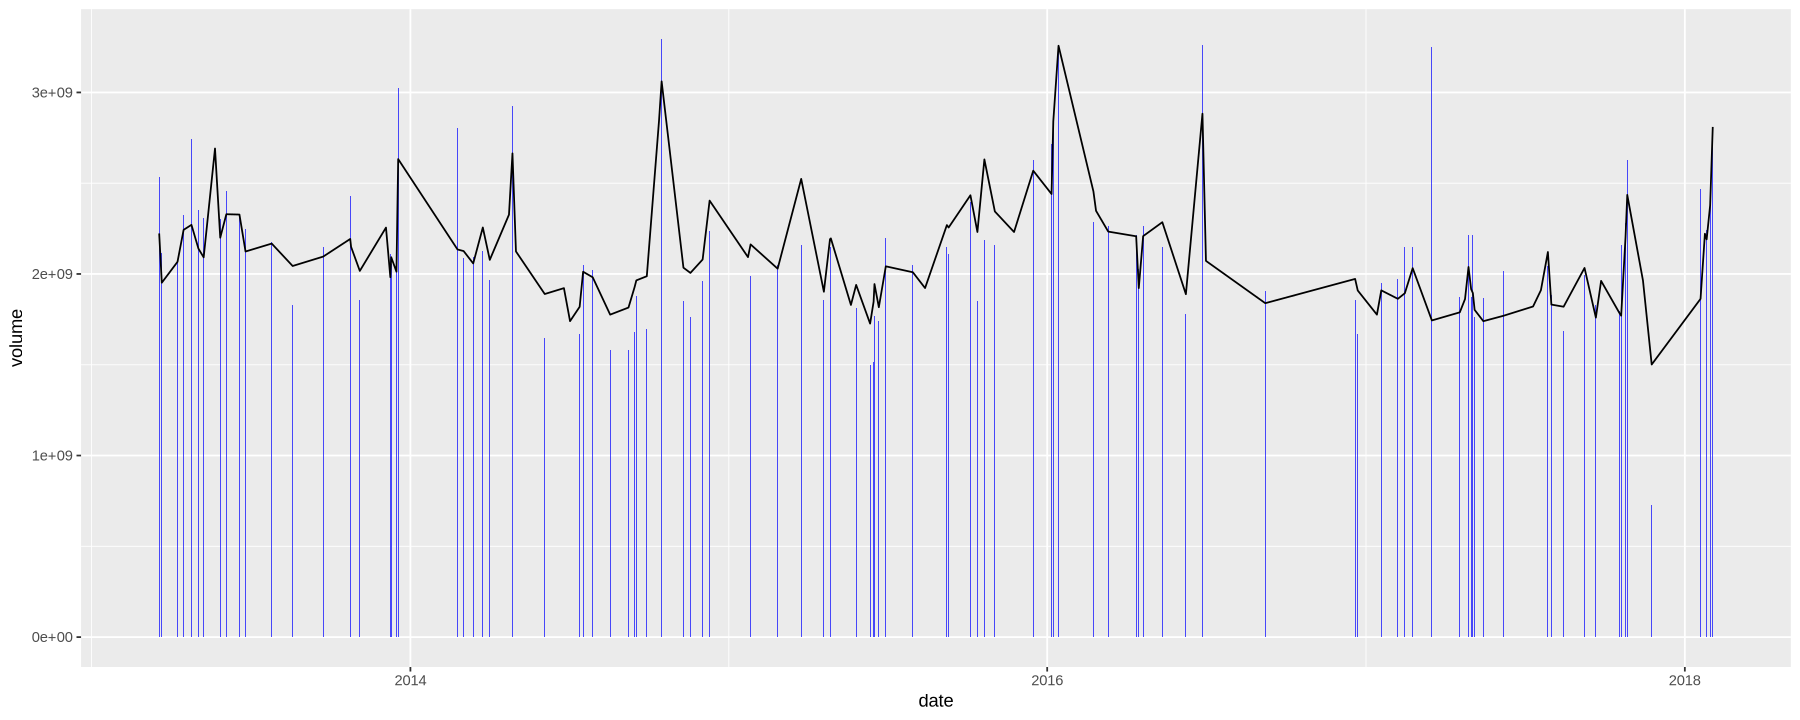

In [24]:
r_df_predict <- as.data.frame(df_predict)

options(repr.plot.width = 15, repr.plot.height = 6)
ggplot2::ggplot(r_df_predict, aes(date, volume)) + 
       ggplot2::geom_bar(stat = "identity", fill = "blue", alpha = 0.7) + 
       ggplot2::geom_line(aes(y = prediction))